In [74]:
import torch
import matplotlib.pyplot as plt
import gpytorch

### Objective Function

In [75]:
def objective(x):
    """
    Objective function is the Forrester function with one global max and one local max, 
    this is the function the GP will try to model
    """

    y = -((x+1)**2)*torch.sin(2*x+2)/5 + 1
    return y.squeeze(-1)

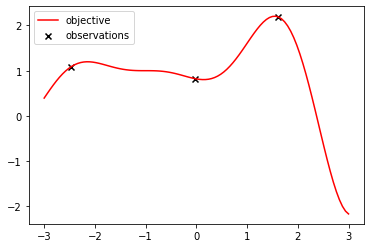

In [76]:
#plot objective function

#true objective function
x = torch.linspace(-3,3,101).unsqueeze(1) #search space
y = objective(x)

#observed quanitities from objective function
torch.manual_seed(0)
train_x = torch.rand(size=(3,1)) * 6 - 3
train_y = objective(train_x)

#plot true and observed
plt.plot(x,y,label='objective', c='r')
plt.scatter(train_x, train_y, marker="x", c='k', label='observations')

plt.legend()

### GP Model

In [77]:
class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        #defines our priors
        self.mean_module = gpytorch.means.ZeroMean() #mean module
        self.covar_module = gpytorch.kernels.RBFKernel() #covariance module, which will use RBF-Kernel, default has variance of 1 
    
    def forward(self,x):
        """Returns a multivariate Normal distribution with predicted mean vector and covariance matricies

        Args:
            x: space to generate predictions
        """
        mean_x = self.mean_module(x) #mean function
        covar_x = self.covar_module(x) #covariance function
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Making Predictions w/o Training

In [78]:
#defines white noise that will be added
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [93]:
model = BaseGPModel(None, None, likelihood)

In [94]:
#default hyperparameters for GP

lengthscale = 1
noise = 1e-4

model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [95]:
def plot_model(model):
    with torch.no_grad():
        #generates predictions for x using our estimated distribution, passed into likelihood function to add white noise
        predictive_distribution = likelihood(model(x))

    #obtain the means for our Multivariate Gaussian
    predictive_mean = predictive_distribution.mean

    pred_lower, pred_upper = predictive_distribution.confidence_region() #prior 

    #get multiple possible functions while ensuring smoothness
    samples = predictive_distribution.sample(torch.Size([5]))

    plt.plot(x, predictive_mean.detach(), label='mean')
    plt.plot(x,y,label='objective')
    plt.fill_between(
        x.flatten(),
        pred_upper,
        pred_lower,
        alpha=0.3,
        label="95% CI"
    )
    for i in range(samples.shape[0]):
        plt.plot(x, samples[i, :], alpha=0.5)
    plt.legend()
    plt.show()

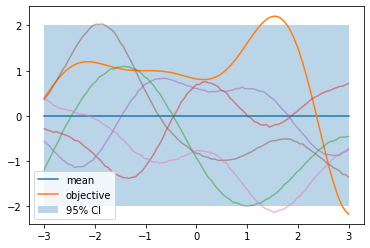

In [96]:
plot_model(model)

### Making Predictions w/ Training

In [99]:
model = BaseGPModel(train_x, train_y, likelihood)

#default hyperparameters for GP
lengthscale = 1
noise = 1e-4

model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

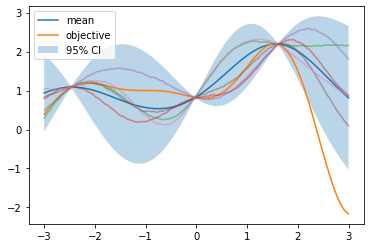

In [100]:
plot_model(model)

### Going Beyond 1-dimensional Objective functions

In [63]:
# training data
train_x = torch.tensor(
    [
        [0., 0.],
        [1., 2.],
        [-1., 1.]
    ]
)

train_y = torch.tensor([0., -1., 0.5])

# test data
grid_x = torch.linspace(-3, 3, 101)

#creating 10,000 by 2 matrix representing data points on 100x100 grid
grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x)
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [64]:
model = BaseGPModel(train_x, train_y, likelihood)

#default hyperparameters for GP
lengthscale = 1
noise = 1e-4

model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [65]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))

#obtain the means for our Multivariate Gaussian
predictive_mean = predictive_distribution.mean

pred_std = predictive_distribution.stddev



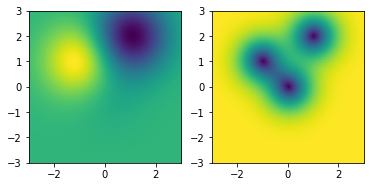

In [66]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3]
)

ax[1].imshow(
    pred_std.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3]
)